In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
from IPython.core.display import HTML

import RVC3 as rvc
import sys, os.path
sys.path.append(os.path.join(rvc.__path__[0], 'examples'))

import numpy as np
from scipy import linalg, stats
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from machinevisiontoolbox import Camera
from spatialmath.base import *
from spatialmath import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
walls_l = Image.Read("walls-l.png", reduce=2); #Загружаются два изображения сцены с левой (walls_l)
                                               # и правой (walls_r) камер,
                                               #при этом разрешение каждого изображения уменьшается
                                               #в два раза (reduce=2) для упрощения обработки.
walls_r = Image.Read("walls-r.png", reduce=2);

In [3]:
#Вычисление SIFT-Дескрипторов
sf_l = walls_l.SIFT() #Для каждого из загруженных изображений вычисляются SIFT-дескрипторы
                       #(sf_l и sf_r), которые позволяют описать и идентифицировать ключевые точки на изображениях.
sf_r = walls_r.SIFT()

SIFTFeature features, 18478 points

In [4]:
#Сопоставление Дескрипторов
matches = sf_l.match(sf_r); #Выполняется сопоставление SIFT-дескрипторов между левым и правым изображениями,
                            #что приводит к созданию объекта matches, содержащего информацию о найденных соответствиях.
matches 

2797 matches

In [5]:
#Оценка Фундаментальной Матрицы
F, resid = matches.estimate(CentralCamera.points2F, confidence=0.99, seed=0) #С помощью метода RANSAC
                                                                   #оценивается фундаментальная матрица F для выбранных соответствий.
                                                                   #Остаточная ошибка resid отражает качество оценки.
F, resid

(array([[-5.754e-08, -5.269e-06, 0.002338],
        [4.942e-06, 3.89e-07, -0.03566],
        [-0.001941,  0.03546,        1]]),
 1.7674501603558275)

In [6]:
##Отбор Согласующихся Точек
matches = matches.inliers # keep only the inliers 
                          #Из всех найденных соответствий сохраняются только те,
                          #которые являются согласующимися (inliers),
                          #т.е. наиболее вероятно принадлежащими одному и тому же объекту на обоих изображениях.
matches 

2389 matches, with 2389 (100.0%) inliers

In [7]:
#Выяснения фокусадинны фокуса
f = walls_l.metadata("FocalLength")

4.15

In [8]:
#Выяснения названия камеры
name = walls_l.metadata("Model")

'iPhone 5s'

In [9]:
#Инициализация Камеры
camera = CentralCamera(name='name', imagesize=walls_l.shape,  #Создается экземпляр CentralCamera с параметрами,
                                                            #полученными из метаданных изображения.
                                                            #Значение фокусного расстояния f переводится из миллиметров в метры.
                       f=f/1000, rho=2*1.5e-6)

           Name: name [CentralCamera]
     pixel size: 3e-06 x 3e-06
     image size: 1224 x 1632
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [     612      816]
   focal length: [ 0.00415  0.00415]

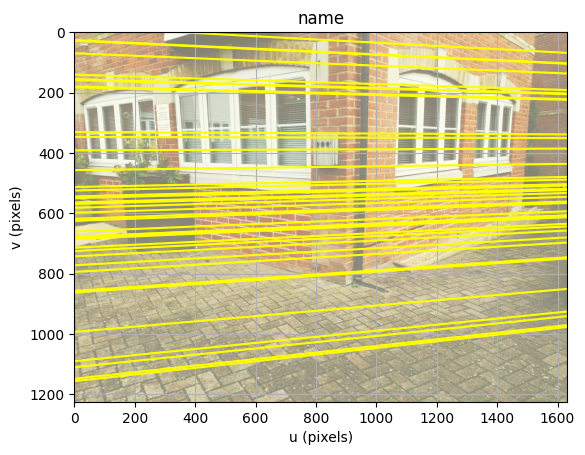

In [10]:
camera.disp(walls_l, alpha=0.5)
camera.plot_epiline(F.T, matches.subset(40).p2, "yellow")
#camera.disp(walls_r, alpha=0.5)
plt.show()

In [11]:
#Делаем предположение что главная точка в центре
#Вычисление Эссенциальной Матрицы и Декомпозици
E = camera.E(F)  #Из фундаментальной матрицы F вычисляется эссенциальная матрица E,
                

array([[ -0.1101,   -10.08,   -2.762],
       [   9.457,   0.7444,   -44.71],
       [   2.845,    45.03,    1.149]])

In [12]:
# Выюираем по предположению клубину точки аж 10 метров в теории и данном примере связь с фокусным расстоянием
# по факту должна быть формула определяющая глубину рзкости плюс дельта
T_1_2 = camera.decomposeE(E, [0, 0, 10]) #а затем производится декомпозиция для определения относительной позиции
                                         #и ориентации второй камеры относительно первой.

   0.9999    0.00797   0.0125   -0.9764    
  -0.007688  0.9997   -0.02241   0.06693   
  -0.01267   0.02231   0.9997   -0.2054    
   0         0         0         1         


In [13]:
T_1_2.printline(orient="camera") 

t = -0.976, 0.0669, -0.205; rpy/yxz = -0.441°, 1.28°, 0.716°


In [14]:
t = T_1_2.t #трансляции t просто отрезаем углы

array([ -0.9764,  0.06693,  -0.2054])

In [15]:
s = 0.3 / t[0] #что фотографии сделаны на расстоянии 30см задаем коэфициент разницы для второй камеры
               # в реальности задаем расстояние между камерами -- вводная переменная 
               # с одной камерой жесткий шаг отладки желательо в каждой плоскости с соблюдением центральной точки фокуса
                   

-0.30725548754584636

In [16]:
T_1_2.t = s * t # scaled translation 
T_1_2.printline(orient="camera") 

t = 0.3, -0.0206, 0.0631; rpy/yxz = -0.441°, 1.28°, 0.716°


In [17]:
# Для понимания но по факту в коде не нужно
#Вычисление Лучей Из Камеры
ray1 = camera.ray(matches[0].p1) #десь ray1 и ray2 представляют лучи, проецируемые из камеры
                                 #в направлении первой согласованной пары точек (matches[0].p1
                                 #на первом изображении и matches[0].p2 на втором соответственно).
                                 #pose=T_1_2 применяется ко второму лучу для учета относительного
                                 #положения и ориентации второй камеры по отношению к первой.

{ 0 0 0; 0.45053 -0.43771 1}

In [18]:
# Для понимания но по факту в коде не нужно
ray2 = camera.ray(matches[0].p2, pose=T_1_2) 

{ -0.0071757 0.27523 0.12379; 0.3282 -0.43513 0.98647}

In [19]:
# Для понимания но по факту в коде не нужно
P, e = ray1.closest_to_line(ray2)  #Метод closest_to_line используется для вычисления ближайшей точки
                                   #между двумя лучами ray1 и ray2, что представляет метод триангуляции
                                   # для нахождения 3D-координат соответствующей точки P в пространстве.
                                   # e — это ошибка или расстояние между лучами в ближайшей точке,
                                   #что дает понимание о точности триангуляции.
print(P)
print(e)


[   1.066   -1.036    2.367]
0.0006718430761683649


In [20]:
#Реальные вычисления используем дальше
#Триангуляция Всех Согласованных Точек
ray1 = camera.ray(matches.p1)
ray2 = camera.ray(matches.p2, pose=T_1_2)
len(ray1)

2389

In [21]:
#Реальные вычисления используем дальше
#вычисления ближайшей точки
P, e = ray1.closest_to_line(ray2)
P

array([[   1.066, -0.03681,    1.961, ...,   0.6783,   0.8129,   0.5067],
       [  -1.036,  -0.9984,   -1.468, ...,   0.2345,   0.1173,    0.185],
       [   2.367,    2.098,    3.345, ...,     1.11,    1.479,    1.248]])

In [22]:
# Посмотреть проверить средняя температура по больнице 
#Вычисляются статистические показатели:
#среднее значение координат Z восстановленных точек  (z.mean()),
z = P[2, :]
z.mean() 

2.233690195931326

In [23]:
#статистика по е
me = np.median(e) # медиана ошибок триангуляции 
emax = e.max()  #и максимальная ошибка Да эта муха в дверь не попадет :)))
print(me)
print(emax)

0.004671581575132002
0.024741940113809688


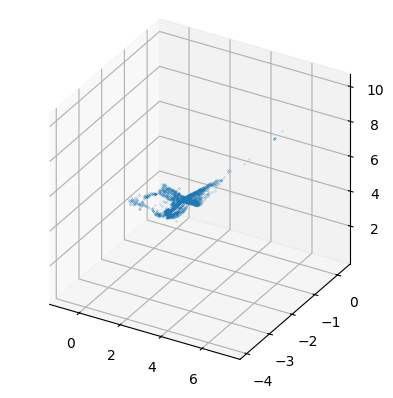

In [24]:
#Выводим на посмотреть как в оригенале из книги замечательный график с завалившейся стеной.
plotvol3()
plt.plot(P[0,:], P[1,:], P[2,:], '.', markersize=0.3)

In [25]:
#Если есть билиотека и посмотреть красиво в правильном виде разкоментировать строку снизу
#walls_pcd = PointCloud(P) 

In [26]:
#Поднимим упавшую стену 
#walls_pcd.transform(SE3.Rx(pi)); # make y-axis upward

In [27]:
#Выведим картинку раскоментировать картинку ниже
#walls_pcd.disp(block=True) #Нажать H Для контроля

In [28]:
#Почистим удалив выбросы
#walls_pcd = walls_pcd.remove_outlier(nb_points=10, radius=0.9) 
                          #Удаление выбросов из облака точек с использованием метода remove_outlier,
                          #который удаляет точки, для которых в заданном радиусе (radius)
                          #находится меньше заданного числа ближайших точек (nb_points).
                          #Это помогает очистить облако точек от шума и аномальных точек.

In [29]:
#Выведим очищенную картинку раскоментировать картинку ниже
#walls_pcd.disp(block=True) #Нажать H Для контроля

In [30]:
#Добавление Цвета к Облаку Точек. Раскоментировать блок ниже.
#colors = [] 
#for m in matches: 
#    colors.append(walls_l.image[int(m.p1[1]), int(m.p1[0]), :])
#pcd = SE3.Rx(pi) * PointCloud(P, colors=np.array(colors).T) 
#pcd.disp(block=True)

In [31]:
p1_reproj = camera.project_point(P[:, 0])           #Перепроекция первой точки из набора P на изображения обеих камер
                                                    #для анализа точности восстановления и согласования.



array([[    1235],
       [   210.5]])

In [32]:
p2_reproj = camera.project_point(P[:, 0], pose=T_1_2)  #Вычисление различий между перепроектированными точками и исходными
                                                       #точками согласований.
                                                       #Это позволяет оценить точность восстановления 3D-позиций и качество триангуляции.

array([[    1053],
       [   248.7]])

In [33]:
(p1_reproj - matches[0].p1).T    #Вычисление различий между перепроектированными точками и исходными
                                 #точками согласований.
                                 #Это позволяет оценить точность восстановления 3D-позиций и качество триангуляции.

array([[       0,    -1025],
       [    1025,        0]])

In [34]:
(p2_reproj - matches[0].p2).T  

array([[-0.06476,   -804.6],
       [   804.9,   0.4298]])

In [35]:
#Прямая коррекция пакета SaM
bundle = BundleAdjust(camera)           #Создается экземпляр BundleAdjust для выполнения регулировки пучка (bundle adjustment)
                                        # — процесса оптимизации, который уточняет 3D-координаты точек, параметры камеры и ее позицию,
                                        #минимизируя проекционные ошибки между наблюдаемыми и предсказанными положениями
                                        #точек на изображениях. Это позволяет улучшить точность восстановленной 3D-модели.

Bundle adjustment problem:  0 views
  0 landmarks
  0 projections
  0 total states
  0 variable states
  0 equations

In [36]:
#Инициализация Видов (Views) для Регулировки Пучка
view0 = bundle.add_view(SE3(), fixed=True)  #Камера 1 
                                            #Создаются два "вида" (view) в объекте bundle для регулировки пучка.
                                             #Первый вид (view0) фиксируется (fixed=True), предполагая,
                                             #что это начальная позиция камеры и она известна точно.
                                             #Второй вид (view1) представляет позицию камеры после перемещения на 0.3
                                             #метра вдоль оси X (SE3.Tx(0.3)).

ViewPoint[view#0, coord=(0, 0, 0, 0, 0, 0)]

In [37]:
view1 = bundle.add_view(SE3.Tx(0.3)) #Камера 2 сдвинутая на 0,3метра

ViewPoint[view#1, coord=(0.3, 0, 0, 0, 0, 0)]

In [38]:
for (Pj, mj) in zip(P[:, ::4].T, matches[::4]): 
   landmark = bundle.add_landmark(Pj) # add vertex 
   bundle.add_projection(view0, landmark, mj.p1) # add edge 
   bundle.add_projection(view1, landmark, mj.p2) # add edge

#то цикл for, который итерируется по парам точек Pj и совпадений mj. 
#P[:, ::4].T извлекает каждую четвертую точку из массива P (вероятно, массива точек в пространстве), 
       #P[:, ::4] использования индексации в массивах в Python с использованием срезов. 
       #: обозначает выбор всех строк в массиве P, 
       # ::4 обозначает выбор каждой четвертой колонки в выбранных строках.
       # пример каждая червертая строка каждый четвертый элемент array[::4, ::4]
#matches[::4] делает то же самое для совпадений (вероятно, массива совпадений точек на изображении).
       #[::4]: Этот срез выбирает каждый четвертый элемент из одномерного массива. 
       #Здесь нет разделения на строки, так как массив одномерный. 
   # zip объединяет эти два списка в пары.
   

In [39]:
bundle #Просто обоьражаем

Bundle adjustment problem:  2 views
    1 locked views: [0]
  598 landmarks
  1196 projections
  1806 total states
  1800 variable states
  2392 equations
  landmarks per view: min=598, max=598, avg=598.0
  views per landmark: min=2, max=2, avg=2.0

In [40]:
x = bundle.getstate(); #Извлекается текущее состояние параметров регулировки
                       


In [41]:
x.shape #пучка в виде вектора x, а затем анализируется его размерность

(1806,)

In [42]:
x[6:12] #Положение второй камеры находиться во втором блоке из 6 элементов

array([     0.3,        0,        0,        0,        0,        0])

In [43]:
x[12:15] #Трансляция за которой следует вращение храниться в данном блоке

array([   1.066,   -1.036,    2.367])

In [44]:
bundle.errors(x)   #Вычисляются ошибки регулировки пучка для текущего состояния параметров,
                   #что позволяет оценить качество текущей модели.

1460028.6994116595

In [45]:
#!Спросить что делает откуда берется параметр r - не выяснено.
#p, A, B = camera.derivatives(t, r, P)
#где t и r представляют собой положение камеры в виде векторов трансляции и вращения, 
# P - это вектор координат ориентировочной точки.
# При сдвиге камеры на d или сдвиге точки.
#и d имеют эквивалентный эффект на изображение, а следовательно,
# Bj  является отрицательным значением первых трех столбцов Aj 
# Теперь все готово для решения задачи коррекции пакета.

In [46]:
x_new, resid = bundle.optimize(x)  #Запускается процесс оптимизации, который пытается минимизировать общую ошибку
                                   #проекций путем коррекции параметров модели, включая положения камер и координаты
                                   #ориентиров. x_new содержит оптимизированные параметры,
                                   #а resid — остаточную ошибку после оптимизации.

Bundle adjustment cost 1.46e+06 -- initial
Bundle adjustment cost 3.04e+03 (solved in 2.08 sec)
Bundle adjustment cost 293 (solved in 2.17 sec)
Bundle adjustment cost 288 (solved in 2.23 sec)
Bundle adjustment cost 288 (solved in 2.25 sec)
Bundle adjustment cost 288 (solved in 2.20 sec)
Bundle adjustment cost 288 (solved in 2.22 sec)

 * 6 iterations in 13.9 seconds
 * Final RMS error is 0.49 pixels


In [47]:
#Применение Оптимизированных Параметров
bundle.setstate(x_new)    #Метод setstate применяет оптимизированный вектор состояния x_new
                          #к объекту регулировки пучка bundle.
                          #Это обновляет параметры модели, включая положения камер
                          #и координаты ориентиров, до их оптимизированных значений.

In [48]:
#Анализ Положения Второго Вида
bundle.views[1].pose.printline(orient="camera")  #Выводится информация о положении и ориентации второй камеры после оптимизации.
                                                 #Это позволяет увидеть, как изменилась позиция и ориентация камеры
                                                 #в результате регулировки пучка.
#По правильному если камеры фиксированы то значения с T_1_2 должны совпасть.
#Или иметь малые отклонения
#В реальности провести анализ на дополнительной паре кадров если то выдать вопрос о неисправности или продолжить выпонение контроль оператора.

t = 0.363, -0.03, 0.0846; rpy/yxz = -0.601°, 1.27°, 0.118°


In [49]:
T_1_2.printline(orient="camera") 

t = 0.3, -0.0206, 0.0631; rpy/yxz = -0.441°, 1.28°, 0.716°


In [50]:
#Анализ Ориентиров
bundle.landmarks[0].P   #Извлекается и выводится позиция первого ориентира (landmark) после оптимизации.
                        #Это дает представление о том, как оптимизация повлияла на расположение ориентиров в 3D-пространстве.

array([   1.066,   -1.036,    2.367])

In [51]:
#Оценка Ошибок После Оптимизации
e = np.sqrt(bundle.getresidual())  #Вычисляется корень из квадратов остаточных ошибок для каждого наблюдения после оптимизации.
                                   #Это позволяет оценить, насколько хорошо оптимизированная модель соответствует наблюдаемым данным.
e.shape       #Выводится размерность массива ошибок, чтобы понять, сколько наблюдений было учтено в процессе регулировки пучка.

(2, 598)

In [52]:
            #где элемент .i; j / представляет собой ошибку 
            #обратной проекции в пикселях для камеры i и ориентировочной точки j.
            #Медианная ошибка для камер один и два
np.median(e, axis=1) 
            #are around a quarter of a pixel

array([  0.2987,   0.2916])

In [53]:
#while the maximum errors
#are less than 2 pixels.
np.max(e, axis=1) 

array([   2.109,    1.986])

In [54]:
#Для анализа посмотреть
#Вычисление Лучей Из Камеры Выводим старый смотрим что совпадает { 0 0 0; 0.45053 -0.43771 1}
ray1 = camera.ray(matches[0].p1)

{ 0 0 0; 0.45053 -0.43771 1}

In [55]:
#Для анализа посмотреть
T_1_2

   0.9999    0.00797   0.0125    0.3       
  -0.007688  0.9997   -0.02241  -0.02056   
  -0.01267   0.02231   0.9997    0.06311   
   0         0         0         1         


In [56]:
#Создаем переменную для новой уточненной трансляции.
vcv = bundle.views[1].pose

   0.9999    0.01053   0.002054  0.3627    
  -0.01048   0.9997   -0.02215  -0.02998   
  -0.002286  0.02213   0.9998    0.08458   
   0         0         0         1         


In [57]:
#Для анализа посмотреть
#Поиск Ближайшей Точки Между Лучами с новой трансляцией сравнить 
#Старый был { -0.0071757 0.27523 0.12379; 0.3282 -0.43513 0.98647}
ray2 = camera.ray(matches[0].p2,  pose=vcv)

{ -0.0071741 0.33229 0.14856; 0.31672 -0.43576 0.98994}

In [58]:
#Для анализа посмотреть
#Для новой
Pn, en = ray1.closest_to_line(ray2) #closest_to_line используется для вычисления ближайшей точки
                                    #между двумя лучами ray1 и ray2,
Pn

array([   1.158,   -1.125,    2.571])

In [59]:
#Для анализа посмотреть
en #Ошибка больше, так как камера 2 откорректирована чем без коррекции там было 0.0006718430761683649 

0.0008208771867972517

In [60]:
#Новая триангуляция всех точек
#Триангуляция Всех Согласованных Точек
ray1 = camera.ray(matches.p1);            #Повторяется процесс вычисления лучей для всех согласованных точек,
                                           #на этот раз используя полные наборы точек matches.p1 и matches.p2.
ray2 = camera.ray(matches.p2, pose=vcv);

In [61]:
#Для анализа посмотреть
len(ray1)

2389

In [62]:
#Вычисления 
Pn, en = ray1.closest_to_line(ray2);       #Применяется метод closest_to_line для каждой пары лучей,
                                           #возвращая массив 3D-координат P всех точек и соответствующие ошибки e.
Pn.shape
Pn

array([[   1.158, -0.04144,        2, ...,   0.7871,   0.9254,   0.5882],
       [  -1.125,   -1.124,   -1.497, ...,   0.2721,   0.1335,   0.2148],
       [   2.571,    2.361,    3.411, ...,    1.288,    1.684,    1.449]])

In [63]:
#Для анализа посмотреть
np.median(e)

0.29526228665340265

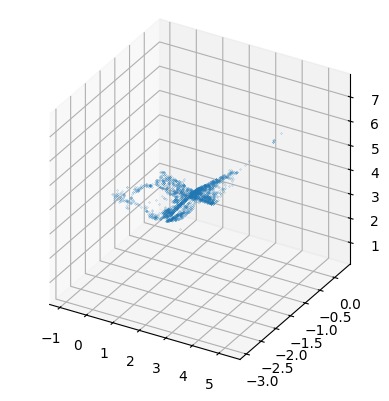

In [64]:
#С использованием функции plotvol3() создается трехмерное пространство для визуализации,
#а затем все восстановленные 3D-точки P отображаются в этом пространстве мелкими точками ('.'),
#что позволяет визуально оценить распределение и точность восстановления геометрии сцены.

plotvol3();
plt.plot(Pn[0,:], Pn[1,:], Pn[2,:], '.', markersize=0.3);

In [65]:
#Красота на посмотреть раскомментировать строки ниже если установлен PointCloud
#walls_pcd = PointCloud(Pn)

In [66]:
#Красота на посмотреть раскомментировать строки ниже
#walls_pcd.transform(SE3.Rx(pi))

In [67]:
#Красота на посмотреть раскомментировать строки ниже
#walls_pcd.disp(block=True) 

In [68]:
#Красота на посмотреть раскомментировать строки ниже
#colors = [] 
#for m in matches: 
#    colors.append(walls_l.image[int(m.p1[1]), int(m.p1[0]), :])
#pcd = SE3.Rx(pi) * PointCloud(Pn, colors=np.array(colors).T) 
#pcd.disp(block=True)

In [69]:
#Немного почистим
#Красота на посмотреть раскомментировать строки ниже
#walls_pcd = walls_pcd.remove_outlier(nb_points=10, radius=0.9) #Удаление выбросов из облака точек с использованием метода remove_outlier,
                          #который удаляет точки, для которых в заданном радиусе (radius)
                          #находится меньше заданного числа ближайших точек (nb_points).
                          #Это помогает очистить облако точек от шума и аномальных точек.

In [70]:
#Красота на посмотреть раскомментировать строки ниже
#walls_pcd.disp(block=True) #Нажать H Для контроля

In [71]:
#Красота на посмотреть раскомментировать строки ниже
#walls_pcd

In [72]:
Pn

array([[   1.158, -0.04144,        2, ...,   0.7871,   0.9254,   0.5882],
       [  -1.125,   -1.124,   -1.497, ...,   0.2721,   0.1335,   0.2148],
       [   2.571,    2.361,    3.411, ...,    1.288,    1.684,    1.449]])

In [73]:
#Сохраним для лога и анализа если надо просто раскоментируй строку
#np.savetxt('my_array.txt', Pn, delimiter=',')

In [74]:
#Сохраним для лога и анализа если надо просто раскоментируй строку
#np.savetxt('my_array.csv', Pn, delimiter=',')

In [75]:
#Подготовим квадраты для захвата
#Можно работь как с логом если высислительной мощноси не достаточно или требется паралельность

In [76]:
"""
#Если хотим работать с логами координат - тут использовать не будем
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt

#----------------можно паралелить на разных вычислителях ---------------------#

# Путь к вашему файлу CSV
file_path = 'my_array.csv'  # Замените на путь к вашему файлу

# Чтение данных из файла
data = pd.read_csv(file_path, header=None)

# Транспонируем DataFrame для удобства работы
points = data.T
points

#----------------можно паралелить на разных вычислителях ---------------------#

#---------------- Для того чтобы не использовать доп библиотеки используем свою матрицу поворотв-------------------#

# Угол поворота в радианах (например, 90 градусов по часовой стрелке)
theta = np.pi / 2  # 90 градусов по часовой стрелке

# Матрица поворота вокруг оси X
rotation_matrix = np.array([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)]
])

# Поворот каждой точки
# Применяем матрицу поворота к каждому столбцу (теперь строка) данных
rotated_data = np.dot(points, rotation_matrix)
rotated_data

#----------------можно паралелить на разных вычислителях ---------------------#

# Преобразование массива NumPy в DataFrame
df = pd.DataFrame(rotated_data)

# Укажите желаемое имя файла
new_file_path = 'pointsRx.csv'

# Сохранение данных в новый файл CSV
df.to_csv(new_file_path, header=False, index=False)

# Выводим сообщение об успешном сохранении
print(f'Данные успешно сохранены в файл {new_file_path}')

#----------------можно паралелить на разных вычислителях ---------------------#

# Транспонируем обратно, если необходимо сохранить исходную структуру
#А нам она тут необходима 
rotated_df = rotated_data.T

# Создаем новый DataFrame из повернутых данных, если нужно работать с DataFrame
rotated_df = pd.DataFrame(rotated_df, index=data.index, columns=data.columns)

# Вывод первых нескольких столбцов повернутых данных для проверки
print(rotated_df.head())
"""

"\n#Если хотим работать с логами координат - тут использовать не будем\n#import pandas as pd\n#import numpy as np\n#import matplotlib.pyplot as plt\n\n#----------------можно паралелить на разных вычислителях ---------------------#\n\n# Путь к вашему файлу CSV\nfile_path = 'my_array.csv'  # Замените на путь к вашему файлу\n\n# Чтение данных из файла\ndata = pd.read_csv(file_path, header=None)\n\n# Транспонируем DataFrame для удобства работы\npoints = data.T\npoints\n\n#----------------можно паралелить на разных вычислителях ---------------------#\n\n#---------------- Для того чтобы не использовать доп библиотеки используем свою матрицу поворотв-------------------#\n\n# Угол поворота в радианах (например, 90 градусов по часовой стрелке)\ntheta = np.pi / 2  # 90 градусов по часовой стрелке\n\n# Матрица поворота вокруг оси X\nrotation_matrix = np.array([\n    [1, 0, 0],\n    [0, np.cos(theta), -np.sin(theta)],\n    [0, np.sin(theta), np.cos(theta)]\n])\n\n# Поворот каждой точки\n# Применяе

In [77]:
#Просто выводим для контроля
Pn

array([[   1.158, -0.04144,        2, ...,   0.7871,   0.9254,   0.5882],
       [  -1.125,   -1.124,   -1.497, ...,   0.2721,   0.1335,   0.2148],
       [   2.571,    2.361,    3.411, ...,    1.288,    1.684,    1.449]])

In [78]:
#Тут мы Pn сразу развернем по простому без библиотек и лишних файлов
#Транспонируем
points = Pn.T
points

array([[   1.158,   -1.125,    2.571],
       [-0.04144,   -1.124,    2.361],
       [       2,   -1.497,    3.411],
       ...,
       [  0.7871,   0.2721,    1.288],
       [  0.9254,   0.1335,    1.684],
       [  0.5882,   0.2148,    1.449]])

In [79]:
#Вращаем
# Угол поворота в радианах (например, 90 градусов по часовой стрелке)
theta = np.pi / 2  # 90 градусов по часовой стрелке
# Матрица поворота вокруг оси X
rotation_matrix = np.array([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)]
])

# Поворот каждой точки
# Применяем матрицу поворота к каждому столбцу (теперь строка) данных
rotated_data = np.dot(points, rotation_matrix)
rotated_data

array([[   1.158,    2.571,    1.125],
       [-0.04144,    2.361,    1.124],
       [       2,    3.411,    1.497],
       ...,
       [  0.7871,    1.288,  -0.2721],
       [  0.9254,    1.684,  -0.1335],
       [  0.5882,    1.449,  -0.2148]])

In [80]:
#Разобьем на квадраты фронтальню стену для передачи в качестве массива точек для нашего будующего контроллера
#Просто математика без всякой кластеризации и ИИ. Так как расстояние между камерами 0,3 пусть квадраты будут 0,2

In [81]:
import pandas as pd

points_df = pd.DataFrame(rotated_data)

# Определение минимальных и максимальных значений для Y и Z
min_y, max_y = points_df[1].min(), points_df[1].max()
min_z, max_z = points_df[2].min(), points_df[2].max()

# Определение количества квадратов по каждой оси
num_squares_y = int((max_y - min_y) / 0.2) + 1
num_squares_z = int((max_z - min_z) / 0.2) + 1

# Инициализация списка для хранения информации о всех мелких квадратах
all_squares_info = []
# Инициализация словаря для хранения точек в каждом квадрате
squares = {}

# Классификация точек по квадратам
for index, row in points_df.iterrows():
    y, z = row[1], row[2]
    square_y = int((y - min_y) / 0.2)
    square_z = int((z - min_z) / 0.2)
    square_key = (square_y, square_z)

    if square_key not in squares:
        squares[square_key] = []
    squares[square_key].append((y, z))

# Количество квадратов с хотя бы одной точкой
len(squares)




116

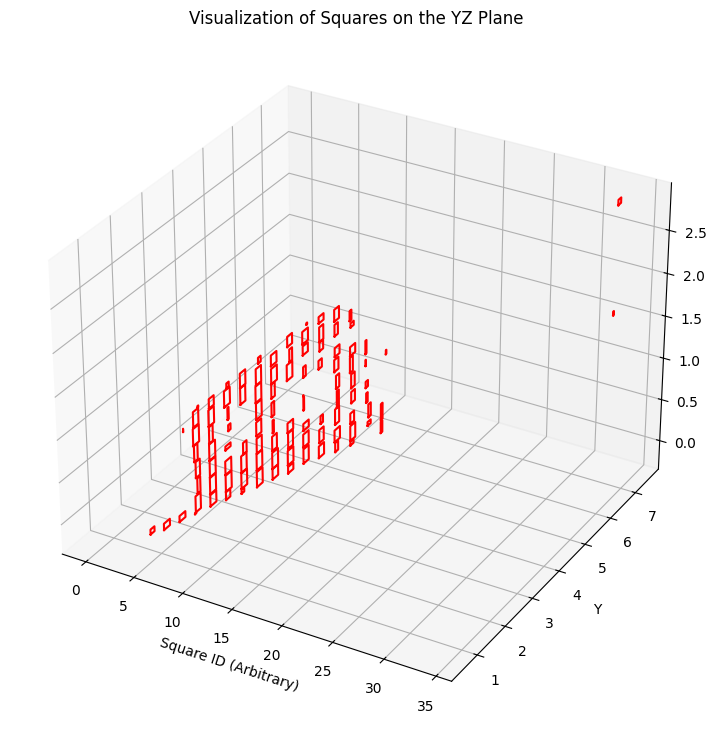

In [82]:
# Подготовка данных для 3D визуализации квадратов на плоскости YZ
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Визуализация каждого квадрата
for square_key, points in squares.items():
    y_values, z_values = zip(*points)
    y_min, y_max = min(y_values), max(y_values)
    z_min, z_max = min(z_values), max(z_values)
    
    # Генерация координат для отрисовки квадратов
    y_corners = [y_min, y_max, y_max, y_min, y_min]
    z_corners = [z_min, z_min, z_max, z_max, z_min]
    x_corners = [square_key[0]] * 5  # Используем номер квадрата в качестве координаты X для визуализации

    # Отрисовка квадрата
    ax.plot(x_corners, y_corners, z_corners, 'r-')

# Настройка названий осей
ax.set_xlabel('Square ID (Arbitrary)')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Visualization of Squares on the YZ Plane')

plt.show()

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

points_df = pd.DataFrame(rotated_data)
# Определение минимальных и максимальных значений для Y и Z
min_y, max_y = points_df[1].min(), points_df[1].max()
min_z, max_z = points_df[2].min(), points_df[2].max()

# Определение количества мелких квадратов по каждой оси для размера 10x10 см
num_small_squares_y = int((max_y - min_y) / 0.2) + 1
num_small_squares_z = int((max_z - min_z) / 0.2) + 1

# Инициализация списка для хранения информации о всех мелких квадратах
all_squares_info = []

# Генерация мелких квадратов и их координат
for y_idx in range(num_small_squares_y):
    for z_idx in range(num_small_squares_z):
        y_center = min_y + (y_idx * 0.2) + 0.05
        z_center = min_z + (z_idx * 0.2) + 0.05
        vertices = np.array([
            [-0.05, -0.05,  0.05,  0.05],  # X coordinates
            [y_center - 0.05, y_center + 0.05, y_center + 0.05, y_center - 0.05],  # Y coordinates
            [z_center - 0.05, z_center - 0.05, z_center + 0.05, z_center + 0.05]   # Z coordinates
        ])
        square_id = (y_idx, z_idx)
        all_squares_info.append((vertices, square_id))

# Инициализация структуры для хранения точек в квадратах
points_in_squares = {idx: [] for idx, _ in enumerate(all_squares_info)}

# Классификация точек по квадратам
for index, row in points_df.iterrows():
    y, z = row[1], row[2]
    square_y = int((y - min_y) / 0.2)
    square_z = int((z - min_z) / 0.2)
    square_index = square_y * num_small_squares_z + square_z
    points_in_squares[square_index].append((y, z))

# Вывод информации только о квадратах с точками
for idx, points in points_in_squares.items():
    if points:  # Проверка, что в квадрате есть точки
        print(f"Квадрат {idx}")
        print("Точки в квадрате:", points)
        # Получение координат вершин квадрата из списка all_squares_info
        vertices, _ = all_squares_info[idx]
        print("Наши искомые точки P можем в контроллер заправлять")
        print("Координаты вершин квадрата:", vertices)
        print()


Квадрат 2
Точки в квадрате: [(0.6015292350289857, 0.23600632869783716)]
Наши искомые точки P можем в контроллер заправлять
Координаты вершин квадрата: [[   -0.05    -0.05     0.05     0.05]
 [  0.6015   0.7015   0.7015   0.6015]
 [  0.1179   0.1179   0.2179   0.2179]]

Квадрат 51
Точки в квадрате: [(1.3312875865932643, -0.2591196561461587), (1.3304893023623676, -0.2587651568466491), (1.323479980363073, -0.25897564969311604), (1.3797400443401466, -0.24270811957680302), (1.3112588681040427, -0.2686230859179767), (1.3835927998515571, -0.23915727615697008), (1.269519241808359, -0.28033757750130645), (1.384323229135682, -0.23497161133971453), (1.3312875865932643, -0.2591196561461587), (1.2782067594963082, -0.2799550952228777), (1.3818705589344773, -0.2498091737438387), (1.3849524312062391, -0.23595871213737066), (1.3733144485831195, -0.24540437788456612), (1.3272598845641073, -0.2641165106668428), (1.3710597792951975, -0.2408161678978687), (1.3569965518082374, -0.25190074742135105), (1.2946

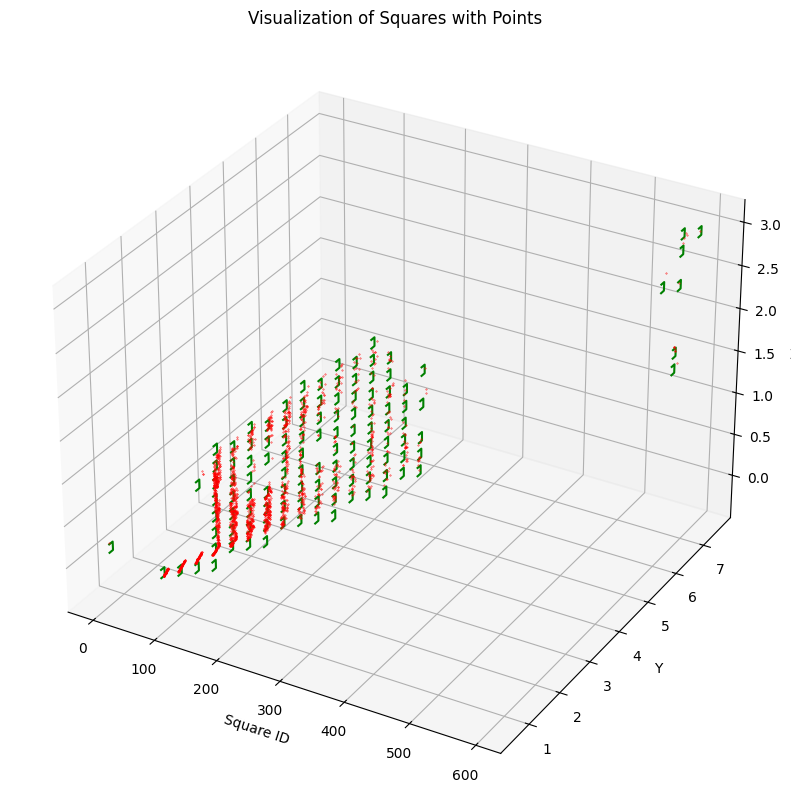

In [84]:
#Как то так все отобразим нумеровать если квадраты их не видно
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Создание 3D графика

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Визуализация квадратов и точек в них
for idx, points in points_in_squares.items():
    if points:  # Визуализируем только квадраты, содержащие точки
        vertices, _ = all_squares_info[idx]
        
        # Координаты для визуализации квадрата
        y_vertices, z_vertices = vertices[1], vertices[2]
        x_vertices = np.full_like(y_vertices, idx)  # Используем idx в качестве координаты X для уникальности
        
        # Визуализация квадрата
        ax.plot(x_vertices, y_vertices, z_vertices, 'g-')
        
        # Визуализация точек
        for y, z in points:
            ax.scatter([idx], [y], [z], color='r', s=0.1)

# Настройка осей
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Visualization of Squares with Points')

plt.show()
